In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
# load data
train_set = pd.DataFrame.from_csv('sqf_train_cpw.csv', index_col = False)
test_set = pd.DataFrame.from_csv('sqf_test_cpw.csv', index_col = False)

In [3]:
# join and re-split data to get all categories
train_set['set'] = 'train'
test_set['set'] = 'test'
joined_data = train_set.append(test_set)

# select all non-real-valued columns (besides 'set' and 'id') and convert to one-hot encoding
col_names = joined_data.columns
col_names = col_names.difference(['id', 'set', 'suspect.age', 'suspect.weight', 'suspect.height', 'observation.period'])
joined_data = pd.get_dummies(data=joined_data, columns=col_names, sparse=True)

In [9]:
joined_data.head()

,id,suspect.age,suspect.height,suspect.weight,observation.period,set,additional.associating_False,additional.associating_True,additional.direction_False,additional.direction_True,...,time.period_1,time.period_2,time.period_3,time.period_4,time.period_5,time.period_6,year_2009,year_2010,year_2011,year_2012
0,1565349,-0.016428,0.027557,-0.372207,-0.024228,train,1,NaN,0,1,...,0,NaN,NaN,NaN,0,1,1,0,NaN,NaN
1,2582029,-0.418262,1.007377,-0.719462,-0.225465,train,1,NaN,0,1,...,0,NaN,NaN,NaN,1,0,0,1,NaN,NaN
2,1969776,1.389991,-1.605475,-0.372207,-0.225465,train,1,NaN,0,1,...,0,NaN,NaN,NaN,0,1,1,0,NaN,NaN
3,2324214,1.691367,0.680770,-0.372207,-0.225465,train,1,NaN,1,0,...,0,NaN,NaN,NaN,0,1,0,1,NaN,NaN
4,1722977,-0.518721,1.333983,0.148676,-0.225465,train,1,NaN,1,0,...,1,NaN,NaN,NaN,0,0,1,0,NaN,NaN


In [14]:
# remove redundant columns (binary columns of the form 'variable_False')
redundant_cols = []
for name in list(joined_data):
    if "False" in name:
        redundant_cols.append(name)
joined_data.drop(redundant_cols, inplace=True, axis=1)

In [15]:
# split data again
train = joined_data.loc[joined_data['set'] == 'train']
train = train.drop(['set'], axis=1)
test = joined_data.loc[joined_data['set'] == 'test']
test = test.drop(['set'], axis=1)

In [16]:
# split training data into features and outcome (numpy arrays, to feed to sklearn algorithms)
label_train = np.ravel(train[['found.weapon_True']].values)
pred_train = train.drop(['id', 'arrested_True', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_train = pred_train.values 

In [17]:
# format test data
results = test.copy()
label_test = np.ravel(test[['found.weapon_True']].values)
pred_test = test.drop(['id', 'found.weapon_True', 'arrested_True', 'found.gun_True'], axis=1)
feature_names = list(pred_test.columns.values)
pred_test = pred_test.values 

print results.shape

(296521, 152)


In [57]:
# fit an L1 penalized logistic regression model
logit_classifier = LogisticRegression(penalty="l1", solver='liblinear', verbose=2)
logit_classifier.fit(X=pred_train, y=label_train)

logit_predictions = logit_classifier.predict_proba(pred_test)[:, 1]
results['preds'] = logit_predictions
print roc_auc_score(label_test, logit_predictions)

logit_predictions_class = logit_classifier.predict(pred_test)
print accuracy_score(label_test, logit_predictions_class, normalize=True)

[LibLinear]0.829250266101
0.96460621676


In [45]:
# for different threshold values, select the features which remain in the model
model = SelectFromModel(logit_classifier, prefit=True, threshold=.5)
pred_test_new = model.transform(pred_test)

#print pred_test.shape
#print pred_test_new.shape
print model.get_support()


[False False False False False False False False False False False False
  True False False False False False False False False False  True  True
  True False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False  True False  True False False False False False
 False  True  True False  True False  True False False  True  True  True
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False  True False False  True  True False False False False False False
 False False  True  True False False False  True  True  True False False
 False False  True  True False False False False False False False  True
 False  True  True False False False False False False False False False
  True  True False False]


In [46]:
feature_importances = list(model.get_support())
feature_list = []
for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i], feature_importances[i]))

#get the names of the features from the previous cell
print sorted(feature_list, reverse=True, key=lambda x: x[1])

[('additional.sights_True', True), ('location.housing_housing', True), ('location.housing_neither', True), ('location.housing_transit', True), ('precinct_9', True), ('precinct_24', True), ('precinct_26', True), ('precinct_41', True), ('precinct_42', True), ('precinct_44', True), ('precinct_46', True), ('precinct_49', True), ('precinct_50', True), ('precinct_52', True), ('precinct_76', True), ('precinct_102', True), ('precinct_105', True), ('precinct_106', True), ('precinct_115', True), ('precinct_120', True), ('stopped.bc.bulge_True', True), ('stopped.bc.casing_True', True), ('stopped.bc.clothing_True', True), ('stopped.bc.object_True', True), ('stopped.bc.other_True', True), ('suspect.race_black', True), ('suspect.race_native.american', True), ('suspect.race_other', True), ('year_2009', True), ('year_2010', True), ('suspect.age', False), ('suspect.height', False), ('suspect.weight', False), ('observation.period', False), ('additional.associating_True', False), ('additional.direction_T

In [49]:
# train a new model based just on features selected above
#predictors = ['location.housing_housing', 'location.housing_neither', 'stopped.bc.object_True', 'stopped.bc.bulge_True', 'additional.sights_True']
predictors = ['location.housing_housing', 'location.housing_neither','stopped.bc.object_True', 'stopped.bc.bulge_True', 'additional.sights_True']

pred_train = train[predictors]
pred_train = pred_train.values 
pred_test = test[predictors]
feature_names = list(pred_test.columns.values)
pred_test = pred_test.values 


# How does AUC change as you add/subtract features?

logit_classifier_simple = LogisticRegression(solver='liblinear', verbose=2)
logit_classifier_simple.fit(X=pred_train, y=label_train)

logit_predictions_simple = logit_classifier_simple.predict_proba(pred_test)[:, 1]
results['preds_simple'] = logit_predictions_simple
print roc_auc_score(label_test, logit_predictions_simple)

print logit_classifier_simple.coef_



[LibLinear]0.76393828085
[[-3.13929127 -2.34887376  2.72326046  0.55668889  0.90773781]]


In [58]:
# add a column which contains the unit weighted heuristic score derived from the features from the previous cell
results['heuristic_score'] = results[['stopped.bc.object_True', 'stopped.bc.bulge_True', 'additional.sights_True']].sum(axis=1)
print results[['stopped.bc.object_True', 'stopped.bc.bulge_True', 'additional.sights_True', 'heuristic_score', 'preds']].head(20)


    stopped.bc.object_True  stopped.bc.bulge_True  additional.sights_True  \
0                      0.0                    0.0                     0.0   
1                      0.0                    0.0                     0.0   
2                      0.0                    0.0                     0.0   
3                      0.0                    0.0                     0.0   
4                      0.0                    1.0                     0.0   
5                      0.0                    0.0                     0.0   
6                      0.0                    0.0                     0.0   
7                      0.0                    0.0                     1.0   
8                      0.0                    0.0                     1.0   
9                      0.0                    0.0                     0.0   
10                     0.0                    0.0                     0.0   
11                     0.0                    0.0                     0.0   

/Users/rs4606/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/rs4606/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rs4606/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rs4606/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

0.0    210000
1.0     84140
2.0      2310
3.0        71
Name: heuristic_score, dtype: int64
1.0    0.605088
Name: found.weapon_True, dtype: float64
0.291787090965


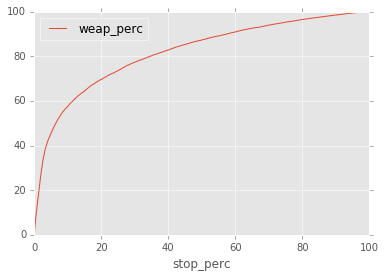

In [67]:
# Plotting question:
# Make a recovery plot: if you used the logistic model to rank stops by model-predicted likelihood of weapon recovery, 
# from highest to lowest, what percent of weapons would you recover if you made the best x percent of stops?
# The plot should have percent of stops on the x axis and percent weapons recovered on the y axis

# HINTS:
# 1) order results by column 'preds'
results = results.sort(['preds'], ascending=False)
# 2) add a column to results which is the cumulative sum of found.weapon_True
plot_data = results[['found.weapon_True', 'preds']]
plot_data['weap_sum'] = plot_data['found.weapon_True'].cumsum()
# 3) use the above cumulative sum to make a column which shows percent weapons recovered
plot_data['weap_perc'] = 100*plot_data['weap_sum']/plot_data['found.weapon_True'].sum()
# 4) add a column which counts the stops
s = [j for j in range(1,296522)]
plot_data['nstop'] = s
# 5) use the above stop count column to make a column which shows percent of all stops
plot_data['stop_perc'] = 100*plot_data['nstop']/plot_data.shape[0]
# 6) restrict to just the columns from 3) and 5), downsample to maybe 1000 rows
plot_data = plot_data[['stop_perc', 'weap_perc']]
rows = random.sample(plot_data.index, 1000)
plot_data = plot_data.ix[rows]
# 7) sort everything in ascending order by the column from 5), then plot.
plot_data = plot_data.sort(['stop_perc'], ascending=True)
plt.figure()
plot_data.plot(x='stop_perc', y='weap_perc')



###### how does the heuristic model perform??
print results['heuristic_score'].value_counts()

score_three = results.loc[results['heuristic_score'].isin([1,2,3])]

print score_three['found.weapon_True'].value_counts()/results['found.weapon_True'].value_counts()
print float(84140 + 2310 + 71)/(84140 + 2310 + 71 + 210000)

In [ ]:
o